# Von Mises Toy

See if I can implement beta without the big list

In [1]:
import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

import tensorflow.keras as tfk
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, Reshape, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfkl = tfk.layers
tfd = tfp.distributions
tfpl = tfp.layers
import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

import numpy as np
from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

tf.keras.backend.set_floatx('float64')

In [3]:
tf.config.list_physical_devices() 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

In [3]:
def plot_latent_space_2(encoder, valid_data, xrange = [0.9,1e6]):
    latent_valid = np.array(encoder.predict(valid_data))
    perms = np.argsort(np.mean(latent_valid[1],axis=0))
    latent_valid = latent_valid[:,:,perms]
    
    #print(latent_valid.shape)
    plt.figure(figsize=(10,2.5))
    plt.subplot(1,2,1)
    
    
    
    plt.scatter(np.exp(-np.mean(latent_valid[1,:,:],axis=0)/2),np.sqrt(np.mean(np.square(latent_valid[0,:,:]),axis=0)),s=10.)
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,1.25])
    plt.ylabel(r'$\sqrt{<\mu^2>}$')
    plt.xlabel(r'$<\sigma>^{-1}$')
    
    plt.subplot(1,2,2)
    
    bins = np.logspace(np.log10(xrange[0]),np.log10(xrange[1]),50)

    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,:20]),axis=0) + np.exp(latent_valid[1,:,:20]))/np.exp(latent_valid[1,:,:20]/2),
         bins=bins,stacked=True)

    plt.xlabel("Inverse resolution")
    plt.semilogx()
    plt.xlim(xrange)
    plt.ylim([0,5e4])





    plt.show()

def plot_latent_space(encoder, valid_data):
    latent_valid = np.array(encoder.predict(valid_data))
    perms = np.argsort(np.mean(latent_valid[1],axis=1))
    latent_valid = latent_valid[:,perms,:]
    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.hist(latent_valid[0,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[0,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("latent means")
    plt.xlim([-5,5])
    plt.legend()
    
    plt.subplot(1,3,2)
    bins = np.logspace(-0.1,4,100)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,0])) + np.exp(latent_valid[1,:,0]))/np.exp(latent_valid[1,:,0]/2),label="latent dimension 1",alpha=0.75,bins=bins)
    plt.hist(np.sqrt(np.mean(np.square(latent_valid[0,:,1])) + np.exp(latent_valid[1,:,1]))/np.exp(latent_valid[1,:,1]/2),label="latent dimension 2",alpha=0.75,bins=bins)
    plt.title("Inverse resolution")
    plt.semilogx()
    plt.xlim([0.9,1e6])
    plt.legend()



    plt.subplot(1,3,3)
    plt.hist(latent_valid[2,:,0],bins=np.arange(-5,5.00001,0.1),label="latent dimension 1",alpha=0.75)
    plt.hist(latent_valid[2,:,1],bins=np.arange(-5,5.00001,0.1),label="latent dimension 2",alpha=0.75)
    plt.title("sampled z")
    plt.xlim([-5,5])
    plt.legend()

    plt.show()
    
def plot_latent_map(encoder, decoder, train_data_banana,
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3]):
    
    
    
    scales = np.array(scales)
    values = np.array(values)
    numpoints = 100
    ranges = scales[:,1]-scales[:,0]

    latent_valid_mu, latent_valid_logvar, latent_valid = np.array(encoder.predict(train_data_banana))
    perms = np.argsort(np.mean(latent_valid_logvar,axis=0))
    
    codes1_proj = np.array([np.vstack([np.ones(numpoints)*value,np.linspace(scales[0,0],scales[0,1],numpoints)]).T for value in values[0]])
    codes2_proj = np.array([np.vstack([np.linspace(scales[1,0],scales[1,1],numpoints),np.ones(numpoints)*value]).T for value in values[1]])

    codes1 = np.zeros((3,numpoints,10))
    codes1[:,:,perms[0]] = codes2_proj[:,:,0]
    codes1[:,:,perms[1]] = codes2_proj[:,:,1]
    codes2 = np.zeros((3,numpoints,10))
    codes2[:,:,perms[0]] = codes1_proj[:,:,0]
    codes2[:,:,perms[1]] = codes1_proj[:,:,1]
#     if long_axis == 0:
#         codes0 = np.array([[code,short_values[0]] for code in codes])
#         codes1 = np.array([[code,short_values[1]] for code in codes])
#         codes2 = np.array([[code,short_values[2]] for code in codes])
#     else:
#         codes0 = np.array([[short_values[0],code] for code in codes])
#         codes1 = np.array([[short_values[1],code] for code in codes])
#         codes2 = np.array([[short_values[2],code] for code in codes])

    fig, ax = plt.subplots(1,2,figsize=(12,3.5),gridspec_kw={'width_ratios': [1, 2]})
    

    
    ax[0].scatter(latent_valid[:,perms[0]],latent_valid[:,perms[1]],color='gray',alpha=0.1,s=0.4)
    ax[1].scatter(train_data_banana[:,0],train_data_banana[:,1],color='gray',alpha=0.1,s=0.4)

    cmap = matplotlib.cm.get_cmap('cool')
    
    for i,codes in enumerate(codes1):
#         points = np.zeros((numpoints,2))
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)
        
    cmap = matplotlib.cm.get_cmap('autumn')
    
    for i,codes in enumerate(codes2):
        color = cmap(i/3.)
        points = decoder.predict(codes)
        ax[1].plot(points[:,0],points[:,1],color = color)
        ax[0].plot(codes[:,perms[0]],codes[:,perms[1]],color = color)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes1)
#     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[1])),s=0.5)

#     points = np.zeros((int(long_range/0.01),2))
#     points = decoder.predict(codes2)
# #     plt.scatter(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])),s=0.5)
#     plt.plot(points[:,0],points[:,1],label=("latent axis " + str(1-long_axis) + " = " + str(short_values[2])))
    ax[1].set_xlim([-2.5,2.5])
    ax[1].set_ylim([-0.75,1.75])
    ax[0].set_xlim(latent_plotrange)
    ax[0].set_ylim(latent_plotrange)
    #plt.legend()

    plt.show()

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

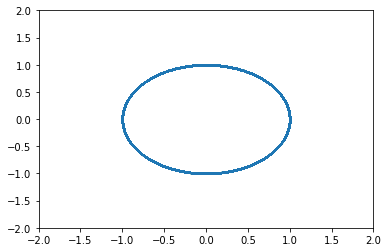

In [4]:
numtrain = 1000000
numvalid = 200000

train_theta = np.random.uniform(-np.pi,np.pi,size=(numtrain))
# train_theta = np.random.normal(size=(numtrain))
train_data = np.zeros((numtrain,2))
train_data[:,0] = np.cos(train_theta)
train_data[:,1] = np.sin(train_theta)

valid_theta = np.random.uniform(-np.pi,np.pi,size=(numvalid))
# valid_theta = np.random.normal(size=(numvalid))
valid_data = np.zeros((numvalid,2))
valid_data[:,0] = np.cos(valid_theta)
valid_data[:,1] = np.sin(valid_theta)



plt.scatter(train_data[:,0],train_data[:,1],s=0.1,alpha=0.1)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### Define VAE

In [5]:
from utils.build_vae_oneparticle import make_vae_oneparticle, make_encoder_oneparticle

In [6]:
class log_vonmisvar(tf.keras.callbacks.Callback):
    
    def __init__(self, encoder, numplot = 1000, numframes = 10000, freqplot = 10,beta = 0.5):
        self.numplot = numplot
        self.freqplot = freqplot
        self.thetas = np.linspace(-np.pi,np.pi,self.numplot,endpoint=False)
#         self.xys = np.zeros((self.numplot,2))
#         self.xys[:,0] = np.cos(self.thetas)
#         self.xys[:,1] = np.sin(self.thetas)
        self.numrecorded = 0
        self.numframes = numframes
        self.vonmisvar = np.zeros((self.numframes,self.numplot))
        self.encoder = encoder
        self.beta = beta
        self.beta_list = np.zeros(self.numframes)
        
    def on_train_batch_begin(self, batch, logs=None):
        if batch%self.freqplot==0:
            self.vonmisvar[self.numrecorded] = self.encoder.predict(self.thetas)[1][:,0].flatten()
            self.beta_list[self.numrecorded] = self.beta
            self.numrecorded = self.numrecorded + 1
            
            if self.numrecorded is self.numframes:
                print("Filled cache")
                self.model.stop_training = True


In [113]:
tf.keras.backend.set_floatx(
    'float64'
)

latent_dims_circle=0
latent_dims_line=5

vae, encoder, decoder = make_vae_oneparticle(loss_type='2D',
                                             real_dim=2,
                                            latent_dims_circle=latent_dims_circle,
                                            latent_dims_line=latent_dims_line,
                                            dense_sizes=[512,512,512,512],
                                            train_batchnorm = True,
                                            precision=tf.float64)

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_36 (Model)                [(None, 5), (None, 5 794634      input_37[0][0]                   
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 1)]          0                                            
___________________________________________________________________________________________

In [369]:
vae.save_weights('vae_weights_0.hdf5')

In [63]:
list(enumerate(np.logspace(np.log10(0.5),-5,8)))

[(0, 0.5),
 (1, 0.10658315582669209),
 (2, 0.022719938211953845),
 (3, 0.004843125429634984),
 (4, 0.001032391184710001),
 (5, 0.00022007102102809866),
 (6, 4.69117278543541e-05),
 (7, 1e-05)]

In [95]:
vae.save_weights('vae_weights_7.hdf5')

In [114]:
last_epoch = 0
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduceLR,earlystop]

alpha = 1.0
alpha_train = np.ones(len(train_data)).astype(np.float64)*alpha
alpha_valid = np.ones(len(valid_data)).astype(np.float64)*alpha

for i, beta in enumerate(np.logspace(0,-5,11)):

    beta_train = np.ones(len(train_data)).astype(np.float64)*beta
    beta_valid = np.ones(len(valid_data)).astype(np.float64)*beta

    K.set_value(vae.optimizer.lr,1e-4)
    
    

    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-10/beta**2
    
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    history = vae.fit(x=[train_data.astype(np.float64)[:500000],beta_train[:500000],alpha_train[:500000]],
                      y=train_data.astype(np.float64)[:500000], batch_size=100,
                    epochs=100000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data.astype(np.float64),beta_valid,alpha_valid],valid_data.astype(np.float64)),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    # tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_test_" + str(i) + "_weights.hdf5")





Setting beta to  1.0 


Train on 500000 samples, validate on 200000 samples
Epoch 1/100000
500000/500000 [==============================] - 156s 312us/sample - loss: 1.0006 - recon_loss: 0.9992 - kl_loss_gauss: 0.0014 - kl_loss_VM: 0.0000e+00 - val_loss: 1.0002 - val_recon_loss: 0.9988 - val_kl_loss_gauss: 0.0014 - val_kl_loss_VM: 0.0000e+00
Epoch 2/100000
500000/500000 [==============================] - 151s 302us/sample - loss: 1.0002 - recon_loss: 0.9986 - kl_loss_gauss: 0.0015 - kl_loss_VM: 0.0000e+00 - val_loss: 1.0001 - val_recon_loss: 0.9995 - val_kl_loss_gauss: 6.3634e-04 - val_kl_loss_VM: 0.0000e+00
Epoch 3/100000
500000/500000 [==============================] - 155s 309us/sample - loss: 1.0002 - recon_loss: 0.9997 - kl_loss_gauss: 4.5428e-04 - kl_loss_VM: 0.0000e+00 - val_loss: 1.0000 - val_recon_loss: 0.9999 - val_kl_loss_gauss: 1.1417e-04 - val_kl_loss_VM: 0.0000e+00
Epoch 4/100000
 99800/500000 [====>.........................] - ETA: 1:50 - loss: 1.0001 - recon_loss: 1.0

KeyboardInterrupt: 

In [112]:
last_epoch = 0
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduceLR,earlystop]

alpha = 1.0
alpha_train = np.ones(len(train_data)).astype(np.float64)*alpha
alpha_valid = np.ones(len(valid_data)).astype(np.float64)*alpha

for i, beta in enumerate(np.logspace(-5,0,11)[1:]):

    beta_train = np.ones(len(train_data)).astype(np.float64)*beta
    beta_valid = np.ones(len(valid_data)).astype(np.float64)*beta

    K.set_value(vae.optimizer.lr,1e-6)
    
    

    print("\n\nSetting beta to ", beta, "\n\n")
    min_delta=1e-10/beta**2
    
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
    earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduceLR,earlystop]

    history = vae.fit(x=[train_data.astype(np.float64)[:500000],beta_train[:500000],alpha_train[:500000]],
                      y=train_data.astype(np.float64)[:500000], batch_size=100,
                    epochs=100000,verbose=1,#initial_epoch=history.epoch[-1],
                    validation_data = ([valid_data.astype(np.float64),beta_valid,alpha_valid],valid_data.astype(np.float64)),
                    initial_epoch = last_epoch,
                    callbacks=callbacks
                  )

    last_epoch = history.epoch[-1]


    # tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
    vae.save_weights("von_mises_test_" + str(i+11) + "_weights.hdf5")





Setting beta to  3.1622776601683795e-05 


Train on 500000 samples, validate on 200000 samples
Epoch 1/100000
500000/500000 [==============================] - 39s 78us/sample - loss: 55.8700 - recon_loss: 1.7220e-08 - kl_loss_gauss: 38.6497 - kl_loss_VM: 0.0000e+00 - val_loss: 54.8215 - val_recon_loss: 1.6384e-08 - val_kl_loss_gauss: 38.4376 - val_kl_loss_VM: 0.0000e+00
Epoch 2/100000
500000/500000 [==============================] - 38s 76us/sample - loss: 55.2263 - recon_loss: 1.6927e-08 - kl_loss_gauss: 38.2995 - kl_loss_VM: 0.0000e+00 - val_loss: 53.8234 - val_recon_loss: 1.5642e-08 - val_kl_loss_gauss: 38.1811 - val_kl_loss_VM: 0.0000e+00
Epoch 3/100000
500000/500000 [==============================] - 38s 77us/sample - loss: 54.7375 - recon_loss: 1.6670e-08 - kl_loss_gauss: 38.0672 - kl_loss_VM: 0.0000e+00 - val_loss: 54.4731 - val_recon_loss: 1.6513e-08 - val_kl_loss_gauss: 37.9599 - val_kl_loss_VM: 0.0000e+00
Epoch 4/100000
363400/500000 [====================>.........] - ETA: 

KeyboardInterrupt: 

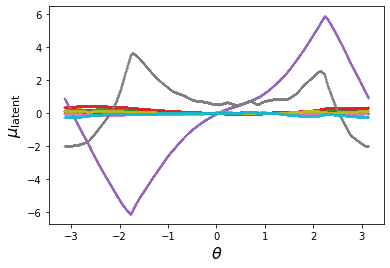

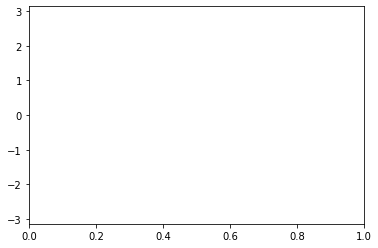

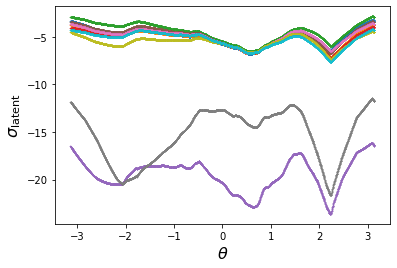

In [111]:
fontsize=16
numplot = 10000

pred = encoder.predict(valid_data[:numplot])

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),np.mod(pred[0][:,dim]+np.pi,(2*np.pi))-np.pi,s=0.1)
plt.ylim([-np.pi,np.pi])    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.show()

In [46]:
fontsize=16
numplot = 10000

pred = encoder.predict(valid_theta[:numplot])

for dim in range(latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[0][:,dim],s=0.1)
    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[1][:,dim],s=0.1)
plt.show()

ValueError: Error when checking input: expected input_37 to have shape (2,) but got array with shape (1,)

In [171]:
beta = 0.2
mylog_vonmisvar.beta = beta


beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

K.set_value(vae.optimizer.lr,1e-5)

history = vae.fit(x=[train_theta,beta_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid],valid_theta),
                initial_epoch = last_epoch,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")

Train on 1000000 samples, validate on 200000 samples
Epoch 17/10000
1000000/1000000 [==============================] - 22s 22us/sample - loss: 3.8817 - recon_loss: 0.0743 - kl_loss: 2.0230 - val_loss: 3.4618 - val_recon_loss: 0.0452 - val_kl_loss: 2.3311
Epoch 18/10000
1000000/1000000 [==============================] - 22s 22us/sample - loss: 3.2681 - recon_loss: 0.0320 - kl_loss: 2.4687 - val_loss: 3.1647 - val_recon_loss: 0.0266 - val_kl_loss: 2.5007
Epoch 19/10000
1000000/1000000 [==============================] - 22s 22us/sample - loss: 3.2689 - recon_loss: 0.0307 - kl_loss: 2.5011 - val_loss: 3.0738 - val_recon_loss: 0.0229 - val_kl_loss: 2.5004
Epoch 20/10000
1000000/1000000 [==============================] - 22s 22us/sample - loss: 3.2682 - recon_loss: 0.0304 - kl_loss: 2.5082 - val_loss: 3.3187 - val_recon_loss: 0.0322 - val_kl_loss: 2.5128
Epoch 21/10000
 999000/1000000 [============================>.] - ETA: 0s - loss: 3.2735 - recon_loss: 0.0305 - kl_loss: 2.5121
Epoch 00021

In [174]:
tfk.models.save_model(vae,"temp_model_1.hdf5")
vae.save_weights("temp_model_1_weights.hdf5")

In [12]:
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)

callbacks = [reduceLR,earlystop,mylog_vonmisvar]

beta = 0.1
mylog_vonmisvar.beta = beta


beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

K.set_value(vae.optimizer.lr,3e-5)

history = vae.fit(x=[train_theta,beta_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid],valid_theta),
                initial_epoch = last_epoch+1,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")

NameError: name 'min_delta' is not defined

In [176]:
tfk.models.save_model(vae,"temp_model_2.hdf5")
vae.save_weights("temp_model_2_weights.hdf5")

In [179]:
beta = 0.2
mylog_vonmisvar.beta = beta


beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

K.set_value(vae.optimizer.lr,3e-5)

history = vae.fit(x=[train_theta,beta_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid],valid_theta),
                initial_epoch = last_epoch+1,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")

Train on 1000000 samples, validate on 200000 samples
Epoch 33/10000
1000000/1000000 [==============================] - 22s 22us/sample - loss: 3.7499 - recon_loss: 0.0371 - kl_loss: 2.8224 - val_loss: 4.2211 - val_recon_loss: 0.0599 - val_kl_loss: 2.7227
Epoch 34/10000
1000000/1000000 [==============================] - 21s 21us/sample - loss: 3.6233 - recon_loss: 0.0388 - kl_loss: 2.6527 - val_loss: 3.4341 - val_recon_loss: 0.0341 - val_kl_loss: 2.5812
Epoch 35/10000
1000000/1000000 [==============================] - 21s 21us/sample - loss: 3.4260 - recon_loss: 0.0363 - kl_loss: 2.5189 - val_loss: 3.1485 - val_recon_loss: 0.0264 - val_kl_loss: 2.4891
Epoch 36/10000
 999000/1000000 [============================>.] - ETA: 0s - loss: 3.3867 - recon_loss: 0.0360 - kl_loss: 2.4861
Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
1000000/1000000 [==============================] - 21s 21us/sample - loss: 3.3883 - recon_loss: 0.0361 - kl_loss: 2.4860 - val_loss:

In [180]:
tfk.models.save_model(vae,"temp_model_3.hdf5")
vae.save_weights("temp_model_3_weights.hdf5")

In [220]:
vae.load_weights("temp_model_3_weights.hdf5")

In [221]:
last_epoch = 43
mylog_vonmisvar.beta_list[(last_epoch+1)*100:]=0
mylog_vonmisvar.numrecorded=(last_epoch+1)*100

In [222]:
beta = 0.05
mylog_vonmisvar.beta = beta


beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

K.set_value(vae.optimizer.lr,1e-5)

history = vae.fit(x=[train_theta,beta_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid],valid_theta),
                initial_epoch = last_epoch+1,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")

Train on 1000000 samples, validate on 200000 samples
Epoch 45/10000
1000000/1000000 [==============================] - 20s 20us/sample - loss: 12.2230 - recon_loss: 0.0236 - kl_loss: 2.7851 - val_loss: 12.2437 - val_recon_loss: 0.0227 - val_kl_loss: 3.1625
Epoch 46/10000
1000000/1000000 [==============================] - 20s 20us/sample - loss: 7.8634 - recon_loss: 0.0108 - kl_loss: 3.5408 - val_loss: 7.6007 - val_recon_loss: 0.0091 - val_kl_loss: 3.9685
Epoch 47/10000
1000000/1000000 [==============================] - 20s 20us/sample - loss: 7.9275 - recon_loss: 0.0087 - kl_loss: 4.4279 - val_loss: 5.7262 - val_recon_loss: 0.0024 - val_kl_loss: 4.7681
Epoch 48/10000
 999000/1000000 [============================>.] - ETA: 0s - loss: 16.1217 - recon_loss: 0.0280 - kl_loss: 4.9275
Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1000000/1000000 [==============================] - 20s 20us/sample - loss: 16.1136 - recon_loss: 0.0280 - kl_loss: 4.9276 - val_lo

In [225]:
beta = 0.1
mylog_vonmisvar.beta = beta


beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

K.set_value(vae.optimizer.lr,1e-5)

history = vae.fit(x=[train_theta,beta_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid],valid_theta),
                initial_epoch = last_epoch+1,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")

Train on 1000000 samples, validate on 200000 samples
Epoch 52/10000
1000000/1000000 [==============================] - 21s 21us/sample - loss: 39.9591 - recon_loss: 0.3499 - kl_loss: 4.9672 - val_loss: 6.2805 - val_recon_loss: 0.0134 - val_kl_loss: 4.9400
Epoch 53/10000
1000000/1000000 [==============================] - 21s 21us/sample - loss: 5.8106 - recon_loss: 0.0088 - kl_loss: 4.9286 - val_loss: 5.2038 - val_recon_loss: 0.0028 - val_kl_loss: 4.9251
Epoch 54/10000
 999000/1000000 [============================>.] - ETA: 0s - loss: 5.5651 - recon_loss: 0.0064 - kl_loss: 4.9230
Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1000000/1000000 [==============================] - 21s 21us/sample - loss: 5.5645 - recon_loss: 0.0064 - kl_loss: 4.9230 - val_loss: 5.4252 - val_recon_loss: 0.0050 - val_kl_loss: 4.9218
Epoch 55/10000
 999000/1000000 [============================>.] - ETA: 0s - loss: 5.7065 - recon_loss: 0.0079 - kl_loss: 4.9214
Epoch 00055: Reduce

In [407]:
np.log(np.exp(9.005)-1)

9.004877198165044

In [413]:
np.linspace(9,9.01,10)

array([9.        , 9.00111111, 9.00222222, 9.00333333, 9.00444444,
       9.00555556, 9.00666667, 9.00777778, 9.00888889, 9.01      ])

In [441]:
nums = np.linspace(9,9.01,10).astype(np.float32)
concentration = np.exp(nums)-1

In [446]:
x=np.array([0.1]).astype(np.float32)

In [447]:
tf.math.bessel_i0e(concentration)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00443219, 0.00442973, 0.00442727, 0.00442481, 0.00442235,
       0.00441989, 0.00441744, 0.00441498, 0.00441253, 0.00441008],
      dtype=float32)>

In [86]:
fontsize=16
numplot = 10000

pred = encoder.predict(valid_theta[:numplot])

for dim in range(latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[0][:,dim],s=0.1)
    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(valid_theta[:numplot],pred[1][:,dim],s=0.1)
plt.show()

ValueError: Error when checking input: expected input_31 to have shape (2,) but got array with shape (1,)

In [760]:


last_epoch = 0

beta = 1.681
alpha = 2.

K.set_value(vae.optimizer.lr,1e-4)

print("\n\nSetting beta to ", beta, "\n\n")
min_delta=1e-6/beta**2
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduceLR,earlystop]

beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

history = vae.fit(x=[train_theta,beta_train, alpha_train], y=train_theta, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_theta,beta_valid, alpha_valid],valid_theta),
                initial_epoch = last_epoch,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


# tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
# vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  1.681 


Train on 1000000 samples, validate on 200000 samples
Epoch 1/10000
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.9048 - recon_loss: 1.3197 - kl_loss_gauss: 0.4377 - kl_loss_vm: 5.0324e-05 - val_loss: 0.9042 - val_recon_loss: 1.3090 - val_kl_loss_gauss: 0.4409 - val_kl_loss_vm: 1.8903e-05
Epoch 2/10000
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.9027 - recon_loss: 1.3230 - kl_loss_gauss: 0.4344 - kl_loss_vm: 4.9397e-05 - val_loss: 0.9045 - val_recon_loss: 1.3175 - val_kl_loss_gauss: 0.4381 - val_kl_loss_vm: 8.4636e-05
Epoch 3/10000
 998000/1000000 [============================>.] - ETA: 0s - loss: 0.9038 - recon_loss: 1.3255 - kl_loss_gauss: 0.4346 - kl_loss_vm: 4.5804e-05
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.9038 - recon_loss: 1.3256 - kl_loss_gauss: 0.4346 - kl_loss_vm: 4.5798

KeyboardInterrupt: 

In [1579]:
latent_dims_circle=10
latent_dims_line=10

vae, encoder, decoder = make_vae_oneparticle(loss_type='2D',
                                             real_dim=2,
                                            latent_dims_circle=latent_dims_circle,
                                            latent_dims_line=latent_dims_line,
                                            dense_sizes=[256,256,256],
                                            vm_thresh=0.,
                                            optimizer = tfk.optimizers.Adam(lr=0.001,clipnorm=0.1))

Model: "model_426"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_319 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_424 (Model)               [(None, 20), (None,  148976      input_319[0][0]                  
__________________________________________________________________________________________________
input_320 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_321 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________

In [1594]:
# vae.load_weights('temp_weights.hdf5')

last_epoch = 0

beta = 1.
alpha = 1.

K.set_value(vae.optimizer.lr,1e-4)

print("\n\nSetting beta to ", beta, "\n\n")
min_delta=1e-6/beta**2
min_delta=0.001
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduceLR,earlystop]

beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

history = vae.fit(x=[train_data,beta_train,alpha_train], y=train_data, batch_size=100,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,beta_valid,alpha_valid],valid_data),
                initial_epoch = last_epoch,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  1.0 


Train on 1000000 samples, validate on 200000 samples
Epoch 1/10000
  72100/1000000 [=>............................] - ETA: 1:15 - loss: 12.8449 - recon_loss: 0.0928 - kl_loss_gauss: 1.7285 - kl_loss_vm: 11.0012

KeyboardInterrupt: 

In [1590]:
vae.save_weights("temp_weights.hdf5")

In [1584]:
# vae.load_weights("temp_weights_1.hdf5")

last_epoch = 0

beta = 100000.
alpha = 1.

K.set_value(vae.optimizer.lr,1e-5)

print("\n\nSetting beta to ", beta, "\n\n")
min_delta=1e-6/beta**2
min_delta=0.0001
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=min_delta, cooldown=0, min_lr=0)
earlystop = tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduceLR,earlystop]

beta_train = np.ones(len(train_data))*beta
beta_valid = np.ones(len(valid_data))*beta
alpha_train = np.ones(len(train_data))*alpha
alpha_valid = np.ones(len(valid_data))*alpha

history = vae.fit(x=[train_data,beta_train,alpha_train], y=train_data, batch_size=1000,
                epochs=10000,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,beta_valid,alpha_valid],valid_data),
                initial_epoch = last_epoch,
                callbacks=callbacks
              )

last_epoch = history.epoch[-1]


tfk.models.save_model(vae,"von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_model.hdf5")
vae.save_weights("von_mises_linear_beta_" + str(beta) + "_" + str(history.epoch[-1]) + "_weights.hdf5")



Setting beta to  100000.0 


Train on 1000000 samples, validate on 200000 samples
Epoch 1/10000
 132000/1000000 [==>...........................] - ETA: 21s - loss: 27.2324 - recon_loss: 0.0209 - kl_loss_gauss: 14.5188 - kl_loss_vm: 12.7131

KeyboardInterrupt: 

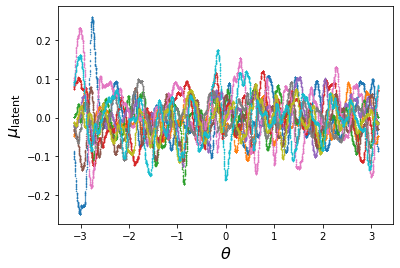

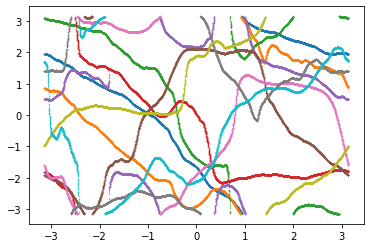

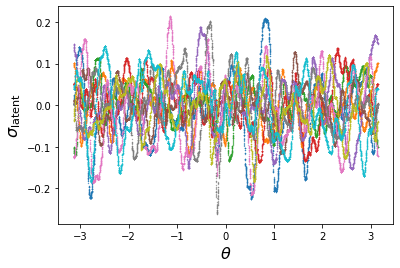

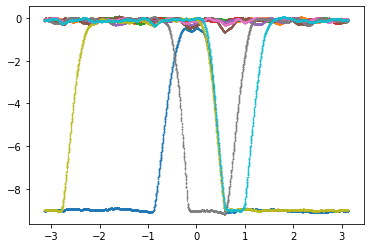

In [1595]:
fontsize=16
numplot = 10000

pred = encoder.predict(valid_data[:numplot])

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[0][:,dim],s=0.1)
    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.show()

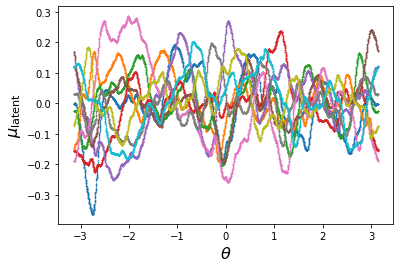

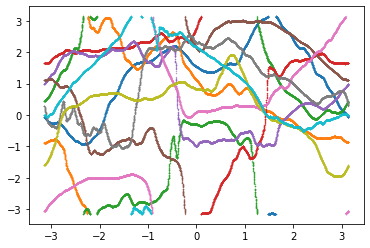

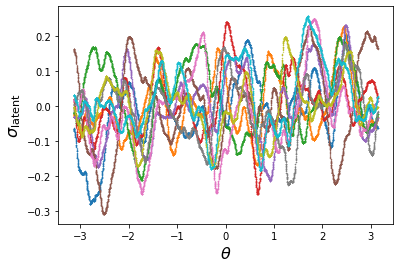

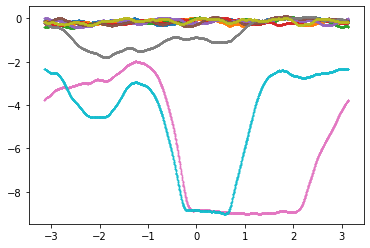

In [1451]:
fontsize=16
numplot = 10000

pred = encoder.predict(valid_data[:numplot])

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[0][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\mu_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[0][:,dim],s=0.1)
    

plt.show()

for dim in range(latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.xlabel(r"$\theta$",fontsize=fontsize)
plt.ylabel(r"$\sigma_\mathrm{latent}$",fontsize=fontsize)
plt.show()

for dim in range(latent_dims_line,latent_dims_circle+latent_dims_line):
    plt.scatter(np.arctan2(valid_data[:numplot,0],valid_data[:numplot,1]),pred[1][:,dim],s=0.1)
plt.show()

In [405]:
latent_dims_circle=0
latent_dims_line=10

vae, encoder, decoder = make_vae_oneparticle(loss_type='2D',
                                             real_dim=2,
                                            latent_dims_circle=latent_dims_circle,
                                            latent_dims_line=latent_dims_line,
                                            dense_sizes=[256,256,256],
                                            vm_thresh=0.)

Model: "model_135"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
model_133 (Model)               [(None, 10), (None,  9812        input_97[0][0]                   
__________________________________________________________________________________________________
input_98 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_134 (Model)               (None, 2)            9154        model_133[1][2]                  
Total params: 18,966
Trainable params: 18,966
Non-trainable params: 0
____________________